# Age Estimation task

## Imports

In [1]:
import numpy as np
import pandas as pd

import scipy
from scipy.stats import skew, kurtosis

import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import seaborn as sns

import librosa
import librosa.display

import warnings
warnings.filterwarnings("ignore")

# %matplotlib widget

## Constants

In [2]:
FILE_DEVELOPMENT = "Dataset/development.csv"
FILE_EVALUATION = "Dataset/evaluation.csv"
AUDIOS_DEVELOPMENT = "Dataset/audios_development/"
AUDIOS_EVALUATION = "Dataset/audios_evaluation/"

precisionLog = {
    'mean_pitch':2, 
    'max_pitch':2, 
    'min_pitch':3, 
    'jitter':2, 
    'shimmer':2, 
    'energy':1, 
    'zcr_mean':2, 
    'spectral_centroid_mean':2,
    'tempo':3,
    'hnr':0
}

precisionLinear = {
    'mean_pitch':-1, 
    'max_pitch':-2, 
    'min_pitch':0, 
    'jitter':3, 
    'shimmer':3, 
    'energy':3, 
    'zcr_mean':2, 
    'spectral_centroid_mean':-2,
    'tempo':3,
    'hnr':0
}

## Data reading

In [3]:
dev_original_df = pd.read_csv(FILE_DEVELOPMENT, header=0, index_col=0)
eval_original_df = pd.read_csv(FILE_EVALUATION, header=0, index_col=0)

audio_dev = os.listdir(AUDIOS_DEVELOPMENT)
audio_eval = os.listdir(AUDIOS_EVALUATION)

In [4]:
print(audio_dev[:5])
print(audio_eval[:5])

['1.wav', '10.wav', '100.wav', '1000.wav', '1001.wav']
['1.wav', '10.wav', '100.wav', '101.wav', '102.wav']


Order audios by integers and increasing order

In [5]:
audio_dev.sort(key=lambda x: int(x.split('.')[0]))
audio_eval.sort(key=lambda x: int(x.split('.')[0]))

print(audio_dev[:5])
print(audio_eval[:5])

['1.wav', '2.wav', '3.wav', '4.wav', '5.wav']
['1.wav', '2.wav', '3.wav', '4.wav', '5.wav']


## Tabular Data Exploration

In [6]:
# display(dev_original_df.head())

display(f"Total number of nan in development: {dev_original_df.isna().sum().sum()}")
display(f"Total number of nan in evaluation: {eval_original_df.isna().sum().sum()}")

desc_dev_df = dev_original_df.describe()
desc_eval_df = eval_original_df.describe()

sampling_rate = dev_original_df['sampling_rate'].iloc[0]

display(desc_dev_df.loc['std', 'sampling_rate'])
display(desc_eval_df.loc['std', 'sampling_rate'])

dev_df = dev_original_df.drop('sampling_rate', axis=1)
eval_df = eval_original_df.drop('sampling_rate', axis=1)

ages_df = dev_df[['age']]
path_dev_df = dev_df[['path']]
path_eval_df = eval_df[['path']]

dev_df = dev_df.drop(['path'], axis=1)
eval_df = eval_df.drop('path', axis=1)

display(dev_df.head())
display(eval_df.head())

'Total number of nan in development: 0'

'Total number of nan in evaluation: 0'

np.float64(0.0)

np.float64(0.0)

,age,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,,
0,24.0,female,arabic,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,[151.99908088],-123.999726,69,281,39,23.846893
1,22.5,female,hungarian,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,[129.19921875],-86.928478,69,281,21,19.388662
2,22.0,female,portuguese,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,[117.45383523],-98.450670,69,281,1,21.640998
3,22.0,female,english,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,[117.45383523],-56.459762,69,281,9,19.644127
4,22.0,male,dutch,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,[112.34714674],-80.349204,69,281,11,18.041905


,gender,ethnicity,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_characters,num_pauses,silence_duration
Id,,,,,,,,,,,,,,,,
0,male,spanish,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,[80.74951172],-116.662338,69,281,2,38.198503
1,male,xiang,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,[89.10290948],-78.253824,69,281,27,29.605442
2,male,igbo,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,[123.046875],-71.630742,6,22,2,2.275556
3,female,spanish,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,[123.046875],-101.533013,69,281,31,22.151837
4,male,spanish,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,[112.34714674],-134.914070,69,281,35,22.430476


In [7]:
temp = dev_df['num_words'].value_counts()
display(temp)

et = dev_df['ethnicity'].value_counts()
et

num_words
69    1710
0      409
4      257
3      158
5      148
2       78
1       66
6       62
7       39
8        2
9        2
12       1
10       1
Name: count, dtype: int64

ethnicity
igbo        1081
english      579
arabic       102
mandarin      65
french        63
            ... 
hakka          1
malagasy       1
lingala        1
fang           1
rundi          1
Name: count, Length: 165, dtype: int64

## Preprocess tabular data

### Encoding

#### Ethnicity

In [8]:
def encode_english(X_df:pd.DataFrame):
    X_copy = X_df.copy()

    X_copy['english'] = (X_copy['ethnicity'] == 'english').astype(int)
    X_copy['others'] = (X_copy['ethnicity'] != 'english').astype(int)

    return X_copy.drop(columns='ethnicity', axis=1)

In [9]:
def encode_ethnicity(X_df, ethnie):
    etna = pd.DataFrame(1, columns=ethnie, index=X_df.index)

    aggregated_ethnicity_df = X_df.copy()
    aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'].isin(ethnie)), 'ethnicity'] = 'others'

    for etnia in ethnie:
        aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = etna[etnia]

        # aggregated_ethnicity_df.loc[aggregated_ethnicity_df['ethnicity'] == etnia, etnia] = 1
        aggregated_ethnicity_df.loc[~(aggregated_ethnicity_df['ethnicity'] == etnia), etnia] = 0

    # encoded_ethnicity = pd.get_dummies(aggregated_ethnicity_df['ethnicity'], dtype=int)

    try:
        aggregated_ethnicity_df = aggregated_ethnicity_df.drop(columns=['ethnicity'], axis=1)
    except KeyError:
        pass

    return aggregated_ethnicity_df

In [10]:
enticity_df = dev_df['ethnicity'].value_counts().sort_values(ascending=False)

median_et = enticity_df.median()
display(enticity_df[enticity_df == 1].shape)
display(enticity_df.head(20))
display(enticity_df.tail(10))
# enticity_df[enticity_df > median_et].plot()

etnie_chosen = sorted(list(set(enticity_df[enticity_df > median_et].index)))
display(etnie_chosen)
display(etnie_chosen.__len__())

(58,)

ethnicity
igbo          1081
english        579
arabic         102
mandarin        65
french          63
korean          52
portuguese      48
russian         48
dutch           47
german          36
polish          34
italian         33
urhobo          32
japanese        27
ibibio          27
macedonian      26
farsi           23
cantonese       23
igala           22
amharic         20
Name: count, dtype: int64

ethnicity
faroese        1
nandi          1
nuer           1
dinka          1
mortlockese    1
hakka          1
malagasy       1
lingala        1
fang           1
rundi          1
Name: count, dtype: int64

['albanian',
 'amharic',
 'arabic',
 'armenian',
 'azerbaijani',
 'bambara',
 'belarusan',
 'bengali',
 'bosnian',
 'bulgarian',
 'cantonese',
 'catalan',
 'congolese',
 'croatian',
 'czech',
 'danish',
 'dari',
 'dutch',
 'english',
 'estonian',
 'fanti',
 'farsi',
 'fijian',
 'finnish',
 'french',
 'ga',
 'georgian',
 'german',
 'greek',
 'gujarati',
 'hausa',
 'hebrew',
 'hindi',
 'hungarian',
 'ibibio',
 'icelandic',
 'igala',
 'igbo',
 'ika',
 'indonesian',
 'italian',
 'japanese',
 'kambaata',
 'kazakh',
 'khmer',
 'kikuyu',
 'kiswahili',
 'korean',
 'krio',
 'kurdish',
 'lao',
 'latvian',
 'lithuanian',
 'macedonian',
 'malay',
 'malayalam',
 'mandarin',
 'marathi',
 'mende',
 'miskito',
 'mongolian',
 'nepali',
 'nigerian',
 'norwegian',
 'obudu',
 'oromo',
 'pashto',
 'polish',
 'portuguese',
 'pulaar',
 'punjabi',
 'romanian',
 'russian',
 'tiv',
 'urhobo',
 'yoruba']

76

#### Gender

In [11]:
def encode_gender_one_hot(X_df:pd.DataFrame):
    X_copy = X_df.copy()

    X_copy['male'] = (X_copy['gender'] == 'male').astype(int)
    X_copy['female'] = (X_copy['gender'].isin(['female','famale'])).astype(int)

    return X_copy.drop(columns='gender', axis=1)

In [12]:
GenderMapper = {
    'male': 1,
    'female': -1
}

def encode_gender(X_df:pd.DataFrame, mapper):
    encoded_df = X_df.copy()
    for gender, value in mapper.items():
        encoded_df.loc[encoded_df['gender'] == gender, 'gender'] = value

    encoded_df.loc[encoded_df['gender'] == 'famale', 'gender'] = -1

    encoded_df['gender'] = encoded_df['gender'].astype(float)
    return encoded_df

#### Tempo

In [13]:
# display(encoded_gender_etnicity_df['tempo'])

def encode_tempo(X_df):
    encoded_df = X_df.copy()
    encoded_df['tempo'] = encoded_df['tempo'].map(lambda x: float(x.strip('[').strip(']')))
    return encoded_df


#### Results

In [14]:
display(eval_df.loc[eval_df['ethnicity'].isin(etnie_chosen), 'ethnicity'].value_counts())

# FOR NOW, WE WILL DROP ETHNICITY #TODO:

# step1_dev_df = dev_df.drop(columns='ethnicity', axis=1)
# step1_eval_df = eval_df.drop(columns='ethnicity', axis=1)

# step1_dev_df = encode_english(dev_df)
# step1_eval_df = encode_english(eval_df)

step1_dev_df = encode_ethnicity(dev_df, etnie_chosen)
step1_eval_df = encode_ethnicity(eval_df, etnie_chosen)

step2_dev_df = encode_gender_one_hot(step1_dev_df)
step2_eval_df = encode_gender_one_hot(step1_eval_df)

# step2_dev_df = encode_gender(step1_dev_df, GenderMapper)
# step2_eval_df = encode_gender(step1_eval_df, GenderMapper)

step3_dev_df = encode_tempo(step2_dev_df)
step3_eval_df = encode_tempo(step2_eval_df)

display(step3_dev_df.head(5))
display(step3_eval_df.head(5))

# display(step3_eval_df[step3_eval_df['yoruba'] == 1])
# display(eval_df.loc[75, :])

display(step3_dev_df.describe())
display(step3_eval_df.describe())

ethnicity
igbo         232
yoruba         5
igala          4
ibibio         2
congolese      1
urhobo         1
nigerian       1
hausa          1
Name: count, dtype: int64

,age,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba,male,female
Id,,,,,,,,,,,,,,,,,,,,,
0,24.0,1821.6906,3999.7170,145.43066,0.013795,0.082725,0.002254,0.210093,3112.257251,151.999081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,22.5,1297.8187,3998.8590,145.37268,0.025349,0.096242,0.007819,0.078849,1688.016389,129.199219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2,22.0,1332.8524,3998.8025,145.42395,0.019067,0.119456,0.002974,0.105365,2576.901706,117.453835,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
3,22.0,1430.3499,3998.4510,147.98083,0.017004,0.102389,0.022371,0.173701,3269.751413,117.453835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,22.0,1688.7234,3998.6113,145.44772,0.028027,0.124831,0.005369,0.107279,1930.897375,112.347147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,...,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba,male,female
Id,,,,,,,,,,,,,,,,,,,,,
0,1056.91740,3945.1610,145.38750,0.022082,0.171076,0.003136,0.032963,1549.607050,80.749512,-116.662338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,1231.84570,3999.1720,145.56432,0.026571,0.132585,0.006783,0.123895,2344.817369,89.102909,-78.253824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,958.29065,3445.4490,145.67374,0.018044,0.096289,0.004478,0.089149,1939.574896,123.046875,-71.630742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,1396.54170,3998.8948,145.41223,0.027290,0.088901,0.014893,0.097054,1832.059113,123.046875,-101.533013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
4,1633.86770,3999.7632,145.36313,0.021621,0.103855,0.001369,0.140950,2534.611168,112.347147,-134.914070,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


,age,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,...,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba,male,female
count,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,...,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000,2933.000000
mean,27.897886,1189.536569,3779.570485,146.934930,0.021190,0.107741,0.005208,0.104774,2176.369847,125.085771,...,0.016365,0.001023,0.003409,0.006819,0.016365,0.001364,0.010910,0.004091,0.499489,0.500511
std,13.093316,414.193673,532.847869,3.757917,0.006626,0.029005,0.006074,0.051646,578.925294,33.812698,...,0.126898,0.031971,0.058301,0.082309,0.126898,0.036911,0.103899,0.063844,0.500085,0.500085
min,6.000000,346.974330,935.515560,145.349140,0.007292,0.045205,0.000028,0.015947,692.116731,51.679688,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,818.922360,3948.234400,145.419140,0.016734,0.087378,0.001960,0.060733,1740.756716,103.359375,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,23.000000,1208.998300,3998.397200,145.622010,0.020525,0.104697,0.003716,0.098964,2150.814043,117.453835,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,32.000000,1523.777700,3999.485400,146.820890,0.024558,0.124993,0.006338,0.139559,2566.190670,143.554688,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,97.000000,2724.892800,3999.792500,202.040700,0.096153,0.265167,0.129114,0.335976,4144.132595,287.109375,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,...,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba,male,female
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,...,691.0,691.0,691.0,691.0,691.0,691.0,691.000000,691.000000,691.000000,691.000000
mean,1191.041077,3832.214580,146.591685,0.021320,0.110438,0.005074,0.105111,2214.701841,126.437846,-84.551539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001447,0.007236,0.568741,0.431259
std,379.826928,451.201809,3.212186,0.006399,0.029365,0.005430,0.050162,571.250581,33.134285,36.514264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.038042,0.084817,0.495611,0.495611
min,419.396150,1151.012200,145.349230,0.009395,0.035001,0.000056,0.018496,803.534172,54.978391,-155.826124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,865.617580,3955.649050,145.401825,0.017184,0.089501,0.001851,0.064549,1785.536118,103.359375,-112.362377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
50%,1209.680400,3998.631300,145.529140,0.020670,0.106233,0.003582,0.098416,2174.406614,123.046875,-92.686476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.000000
75%,1487.326050,3999.521850,146.396920,0.024536,0.126537,0.006147,0.135834,2580.589333,143.554688,-59.687405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,1.000000
max,2201.411000,3999.790800,186.688950,0.077450,0.246068,0.048074,0.335676,4753.076563,258.398438,11.653742,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000


### Behavior analysis and $log_{10}$ scaling

#### Insight

In [15]:
def create_colors(values:pd.Series, label:str, use_continous:bool=False, 
                  cmap_continuous = cm.viridis, cmap_discrete = cm.rainbow):
    if use_continous:
        cmap_ = cmap_continuous
        # Alternative normalization without iterquartile ranges:
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap_)
        handles = None
    else:
        cmap_ = cmap_discrete
        norm = plt.Normalize(vmin=np.min(values), vmax=np.max(values)) 
        
        mappable = None
        handles = [
            Line2D(
                [0], [0], marker='o', color='none', linestyle='None', 
                markeredgewidth=0, markerfacecolor=cmap_(norm(val)), 
                markersize=10, label=label
            ) for label, val in GenderMapper.items()
        ]

    return cmap_, norm, mappable, handles 

def round_column(data: pd.DataFrame, col: str, isLog:bool = True):
    if col != 'hnr':
        if isLog:
            rounded_col = np.round(
                np.log10(data[col]), 
                precisionLog[col]
            )
        else:
            rounded_col = np.round(
                data[col],
                precisionLinear[col]
            )
    else:
        rounded_col = np.round(data[col], precisionLinear[col])
    return rounded_col


def perform_aggregation(partition_df, target, gender, descrete):
    grouped_temp = partition_df.groupby(col).agg({
        'frequency': 'first',
    })

    if not descrete:
        grouped_temp['target'] = grouped_temp.index.map(
            lambda val: target.loc[partition_df[partition_df[col] == val].index, :].mean().iloc[0]
        )
    else:
        grouped_temp['target'] = GenderMapper[gender]

    grouped_temp = grouped_temp.reset_index()

    return grouped_temp
    
def plot_distribution(fig:plt.Figure, ax:plt.Axes, X_df:pd.DataFrame, col:str, target:pd.Series, isLog:bool=True, descrete:bool=False):    
    temp = X_df[['gender', col]].copy()

    temp[col] = round_column(temp, col, isLog=isLog)

    male_df = temp[temp['gender'] == GenderMapper['male']].copy()
    female_df = temp[temp['gender'] == GenderMapper['female']].copy()

    male_df['frequency'] = male_df[col].map(male_df[col].value_counts())
    female_df['frequency'] = female_df[col].map(female_df[col].value_counts())

    male_grouped_df = perform_aggregation(male_df, target, 'male', descrete)
    female_grouped_df = perform_aggregation(female_df, target, 'female', descrete)

    female_grouped_df.index = female_grouped_df.index + male_grouped_df.index[-1]

    combined_df = pd.concat([male_grouped_df, female_grouped_df]).reset_index()

    cmap_, norm, mappable, handles = create_colors(combined_df.loc[:, 'target'], label='gender', use_continous=not descrete)

    sc = ax.scatter(combined_df[col], 
                    combined_df['frequency'], 
                    c=cmap_(norm(combined_df['target'])), 
                    alpha=0.7)

    if mappable:
        fig.colorbar(mappable=mappable, ax=ax)
    else:
        ax.legend(handles=handles)

#TODO: without 'gender' column does not work
def tabular_data_distribution():
    for i in range(9):
        col = list(precisionLog.keys())[i]
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'Distribution of {col.capitalize()} in log10 scale')

        ax1 = fig.add_subplot(121)
        plot_distribution(fig, ax1, step3_dev_df, col, ages_df, isLog=True, descrete=True)
        ax1.set_xlabel(f'log_10({col.capitalize()})')
        ax1.set_ylabel(f'Count')
        
        ax2 = fig.add_subplot(122)
        ax2.set_title("Points colored with average age of grouped points")

        plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=True, descrete=False)
        ax2.set_xlabel(f'log_10({col.capitalize()})')
        ax1.set_ylabel(f'Count')
        plt.show()

        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

        ax1 = fig.add_subplot(121)
        plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
        ax1.set_xlabel(f'{col.capitalize()}')
        ax2.set_ylabel(f'Count')
        
        ax2 = fig.add_subplot(122)
        ax2.set_title("Points colored with average age of grouped points")
        plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
        ax2.set_ylabel(f'Count')
        ax2.set_xlabel(f'{col.capitalize()}')
        plt.show()


    col = list(precisionLog.keys())[9]

    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(f'Distribution of {col.capitalize()} in linear scale')

    ax1 = fig.add_subplot(121)
    plot_distribution(fig, ax1, step3_dev_df, col, None, isLog=False, descrete=True)
    ax1.set_xlabel(f'{col.capitalize()}')
    ax1.set_ylabel(f'Count')

    ax2 = fig.add_subplot(122)
    ax2.set_title("Points colored with average age of grouped points")
    plot_distribution(fig, ax2, step3_dev_df, col, ages_df, isLog=False, descrete=False)
    ax2.set_xlabel(f'{col.capitalize()}')
    ax2.set_ylabel(f'Count')
    plt.show()

#### In practice

In [16]:
step3_log_dev_df = step3_dev_df.copy()
step3_log_eval_df = step3_eval_df.copy()

for i, toSub in zip(precisionLog.keys(), [1, 0, 0, 1, 1, 1, 1, 1, 0, 0]):
    if toSub == 1:
        step3_log_dev_df.loc[:, i] = np.log10(step3_dev_df.loc[:, i])
        step3_log_eval_df.loc[:, i] = np.log10(step3_eval_df.loc[:, i])

## Correlation

age                 1.000000
silence_duration    0.514127
num_words           0.473499
num_characters      0.473403
num_pauses          0.437670
mean_pitch          0.327427
zcr_mean            0.313140
jitter              0.270149
english             0.249463
max_pitch           0.226643
Name: age, dtype: float64

ibibio       -0.036063
tempo        -0.040547
macedonian   -0.052054
ika          -0.053159
obudu        -0.053159
igala        -0.060899
urhobo       -0.063865
min_pitch    -0.224201
igbo         -0.426154
hnr          -0.446880
Name: age, dtype: float64

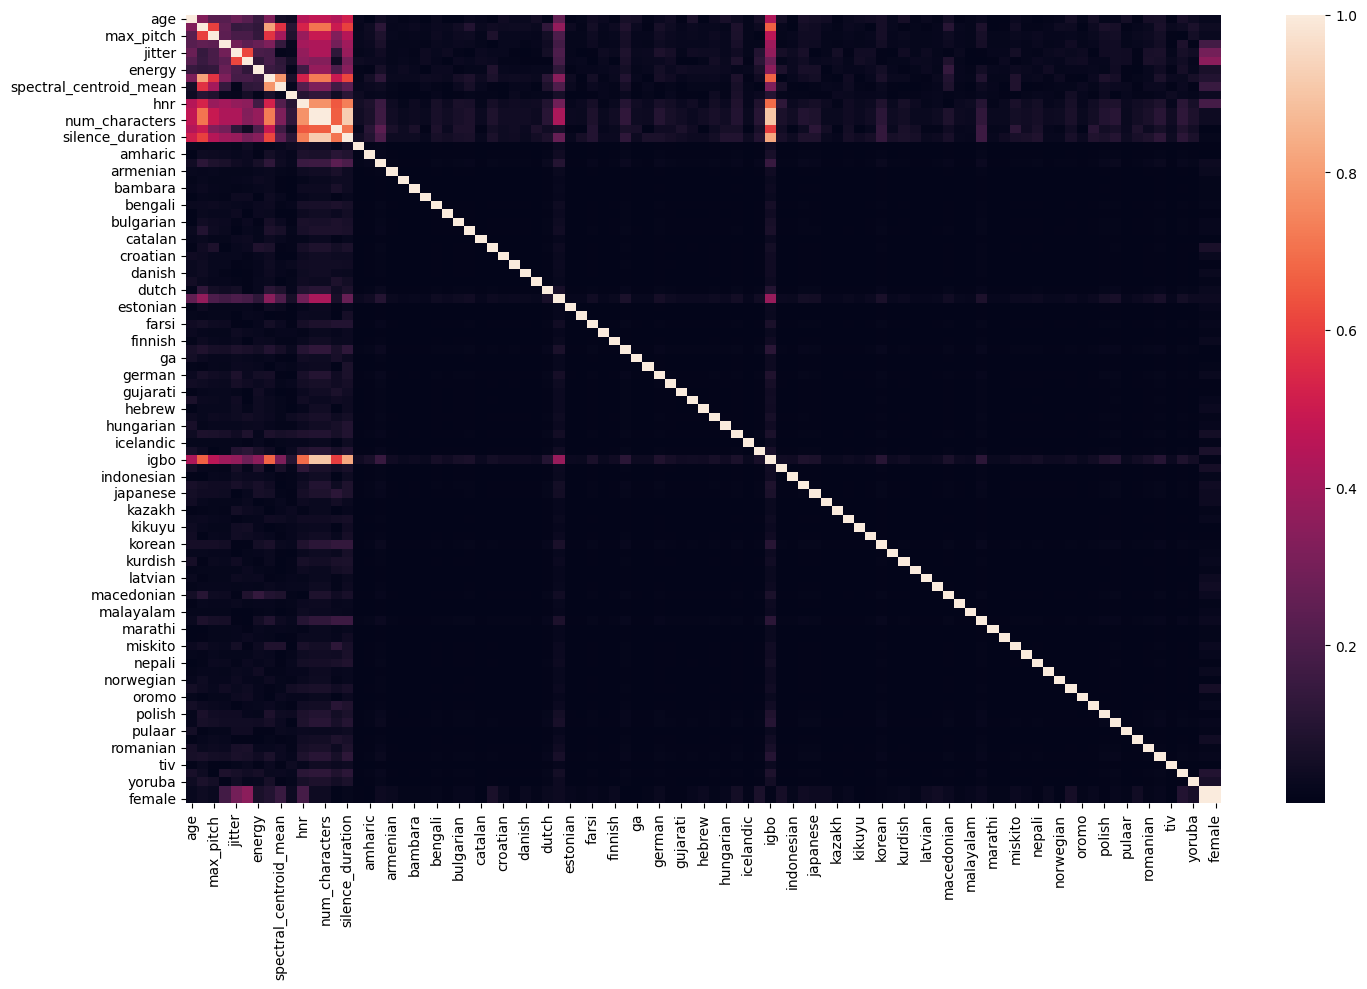

In [17]:
temp:pd.Series = step3_log_dev_df.corr().loc['age', :].sort_values(ascending=False)
display(temp.head(10))
display(temp.tail(10))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()
sns.heatmap(np.abs(step3_log_dev_df.corr()), ax=ax)
plt.tight_layout()

### Standardization

In [18]:
no_age_dev_df = step3_log_dev_df.drop(columns=['age'], axis=1)

scaler = StandardScaler().fit(no_age_dev_df)

step3_log_norm_dev_df = pd.DataFrame(scaler.transform(no_age_dev_df), columns=no_age_dev_df.columns)
step3_log_norm_eval_df = pd.DataFrame(scaler.transform(step3_log_eval_df), columns=step3_log_eval_df.columns)

display(step3_log_norm_dev_df.head())
display(step3_log_norm_eval_df.head())

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,...,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba,male,female
0,1.295444,0.413221,-0.400362,-1.298379,-0.853814,-0.404445,1.534388,1.416622,0.796088,-1.287020,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,-0.998978,0.998978
1,0.406357,0.411611,-0.415793,0.754143,-0.288687,0.855523,-0.277067,-0.777731,0.121675,-0.322635,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,-0.998978,0.998978
2,0.476199,0.411505,-0.402148,-0.206386,0.518159,-0.123477,0.258771,0.739585,-0.225751,-0.622378,...,7.752688,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,-0.998978,0.998978
3,0.661310,0.410845,0.278367,-0.592809,-0.057508,1.920345,1.182793,1.593684,-0.225751,0.469989,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,-0.998978,0.998978
4,1.096713,0.411146,-0.395821,1.093041,0.682511,0.474725,0.292051,-0.295562,-0.376805,-0.151479,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,1.001023,-1.001023


,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,...,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba,male,female
0,-0.132027,0.310818,-0.411849,0.288722,1.859285,-0.069907,-1.889152,-1.084587,-1.311455,-1.096143,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,1.001023,-1.001023
1,0.269560,0.412198,-0.364788,0.913004,0.907538,0.711640,0.558209,0.401067,-1.064363,-0.096969,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,1.001023,-1.001023
2,-0.388885,-0.627155,-0.335666,-0.392564,-0.286866,0.291060,-0.050143,-0.279479,-0.060310,0.075326,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,1.001023,-1.001023
3,0.598590,0.411678,-0.405267,1.003108,-0.584964,1.508214,0.106896,-0.484025,-0.060310,-0.702563,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,-0.998978,0.998978
4,1.010125,0.413308,-0.418335,0.217608,-0.004417,-0.909264,0.796607,0.680233,-0.376805,-1.570950,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,1.001023,-1.001023


## Error plot

In [19]:
def plot_error_distripution(y_pred, y_val, precision):
    errors = pd.DataFrame(np.round(y_pred.flatten() - y_val.values.flatten(), precision), columns=['error'])
    error_counts = errors['error'].value_counts().reset_index()
    error_counts.columns = ['error', 'count']

    plt.figure()
    plt.scatter(error_counts['error'], error_counts['count'])
    plt.xlabel('Error')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Errors')
    plt.show()
    return error_counts

In [20]:
# from sklearn.pipeline import make_pipeline
# from sklearn.model_selection import cross_val_score

# cross_val_score(make_pipeline(StandardScaler(), RandomForestRegressor()), step3_log_dev_df, ages_df, cv=15, scoring='neq_mean_squared_error').mean().abs()

## First regressor

10.576622849207501

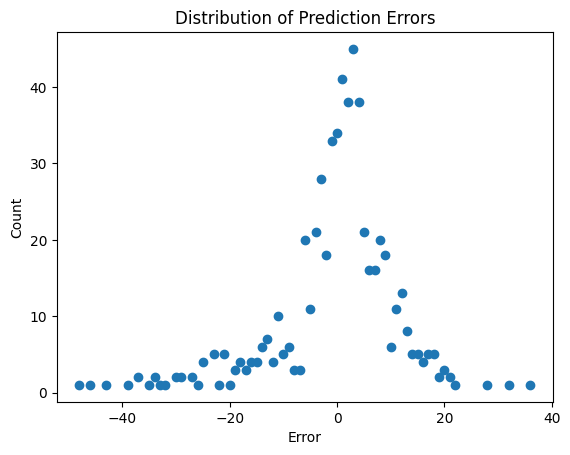

In [21]:
X_train_val_df = step3_log_norm_dev_df.copy()
# X_train_val_df = X_train_val_df.drop(columns=[], axis=1)

forest = RandomForestRegressor(random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.455056281368881

First look to feature importances

In [22]:
sorted(zip(forest.feature_names_in_, forest.feature_importances_), key=lambda x:x[1] , reverse=True)

[('silence_duration', np.float64(0.33546130962707765)),
 ('hnr', np.float64(0.06453508687787342)),
 ('jitter', np.float64(0.06257943270932793)),
 ('num_pauses', np.float64(0.05775209809602884)),
 ('spectral_centroid_mean', np.float64(0.05365818227988742)),
 ('mean_pitch', np.float64(0.052877136301502356)),
 ('energy', np.float64(0.05282486460522276)),
 ('min_pitch', np.float64(0.050000054550184934)),
 ('shimmer', np.float64(0.04977413633699816)),
 ('max_pitch', np.float64(0.04818762872704779)),
 ('zcr_mean', np.float64(0.04134837913502886)),
 ('english', np.float64(0.037880078579963)),
 ('tempo', np.float64(0.03626658761232807)),
 ('female', np.float64(0.004774467865067286)),
 ('male', np.float64(0.004390036051867598)),
 ('greek', np.float64(0.0037380744798690677)),
 ('polish', np.float64(0.003014881672041106)),
 ('croatian', np.float64(0.002452660724975414)),
 ('italian', np.float64(0.002335503953616506)),
 ('congolese', np.float64(0.0020490224896740745)),
 ('japanese', np.float64(0.0

As we can see, only ethnicity "english" seems to give a significant contribution to regressor

In [23]:
step3_log_norm_eval_df.head()

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,...,portuguese,pulaar,punjabi,romanian,russian,tiv,urhobo,yoruba,male,female
0,-0.132027,0.310818,-0.411849,0.288722,1.859285,-0.069907,-1.889152,-1.084587,-1.311455,-1.096143,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,1.001023,-1.001023
1,0.269560,0.412198,-0.364788,0.913004,0.907538,0.711640,0.558209,0.401067,-1.064363,-0.096969,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,1.001023,-1.001023
2,-0.388885,-0.627155,-0.335666,-0.392564,-0.286866,0.291060,-0.050143,-0.279479,-0.060310,0.075326,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,1.001023,-1.001023
3,0.598590,0.411678,-0.405267,1.003108,-0.584964,1.508214,0.106896,-0.484025,-0.060310,-0.702563,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,-0.998978,0.998978
4,1.010125,0.413308,-0.418335,0.217608,-0.004417,-0.909264,0.796607,0.680233,-0.376805,-1.570950,...,-0.128988,-0.031998,-0.058491,-0.08286,-0.128988,-0.036955,-0.105027,-0.064095,1.001023,-1.001023


In [24]:
y_eval_pred = forest.predict(X_train_val_df.values)

display(np.max(y_eval_pred), np.min(y_eval_pred))
display(np.max(ages_df), np.min(ages_df))

np.float64(80.39)

np.float64(16.01)

np.float64(97.0)

np.float64(6.0)

In [25]:
abs(
    cross_val_score(
        RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=341967), 
        X_train_val_df, 
        ages_df, cv=10, 
        scoring='neg_root_mean_squared_error', 
        n_jobs=-1
    ).mean()
)

# abs(
#     croscross_val_score(
#         make_pipeline(StandardScaler(), RandomForestRegressor()), 
#         X_train_val_df, 
#         ages_df, cv=10, 
#         scoring='neg_root_mean_squared_error', 
#         n_jobs=-1
#     ).mean()
# )

np.float64(10.562934394237404)

## Fine tuned

In [26]:
# def grid(builder, configs, cv):
#     gs = GridSearchCV(builder(), configs, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv)
#     gs.fit(X_train.values, y_train.values.reshape((-1,)))
    
#     return gs

# X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

# best = grid(RandomForestRegressor, {'n_estimators': [300, 500], 'random_state': [341967]}, 5)

# y_pred = best.predict(X_val.values)

# display(root_mean_squared_error(y_val, y_pred))
# _ = plot_error_distripution(y_pred, y_val, 0)

#10.424189101247185

## Preprocess audio

### Data exploration

In [27]:
def plot_audio(y:np.ndarray, sr:float, time=False, freq=False, spectrogram=False, mel=False, mfcc=False, hp=False, poly=False,plot=True):
    """
        Returns the thing plotted\n
        If freq = True, returns the frequencies used too\n
        If hp=True, returns Harmonic and Percussion\n
        If all False, returns y
    """
    target_freq_bins = 32
    n_fft = (target_freq_bins - 1) * 2

    if time:
        if plot:
            plt.figure(figsize=(12, 3))
            plt.title(f"Audio {i} as waveform")
            librosa.display.waveshow(y, sr=sr)

        return y
    if freq:
        y_freq = np.abs(scipy.fft.fft(y))
        f = np.linspace(0, sr, len(y_freq))
        
        if plot:
            plt.figure(figsize=(12, 3))
            plt.title(f"Spectrum of audio {i}")
            plt.semilogx(f[: len(f) // 2], y_freq[: len(f) // 2])
            plt.xlabel("Frequency (Hz)")

        return y_freq, f
    if spectrogram:    
        y_stft = np.abs(librosa.stft(y, n_fft=n_fft))
        y_stft_db = librosa.amplitude_to_db(y_stft, ref=np.max)
        
        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"Spectrogram of audio {i}")
            librosa.display.specshow(y_stft_db, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.1f dB")

        return y_stft, y_stft_db
    if mel:
        y_mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=32)
        y_mel_db = librosa.power_to_db(y_mel, ref=np.max)

        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"Mel-spectrogram of audio {i}")
            librosa.display.specshow(y_mel_db, sr=sr, x_axis="time", y_axis="mel")
            plt.colorbar(format="%.2f dB")
        
        return y_mel, y_mel_db
    if mfcc:
        y_mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        
        if plot:
            plt.figure(figsize=(12, 4))
            plt.title(f"MFCC of audio {i}")
            librosa.display.specshow(y_mfccs, sr=sr, x_axis="time")
            plt.colorbar()

        return y_mfccs
    if hp:
        y_stft = librosa.stft(y, n_fft=n_fft)
        H, P = librosa.decompose.hpss(y_stft)
        Hmag = np.abs(H)
        Pmag = np.abs(P)

        if plot:
            Hdb = librosa.amplitude_to_db(Hmag, ref=np.max)
            Pdb = librosa.amplitude_to_db(Pmag, ref=np.max)
            
            plt.figure(figsize=(12, 4))
            plt.title(f"Harmonic source of audio {i}")
            librosa.display.specshow(Hdb, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.2f dB")

            plt.figure(figsize=(12, 4))
            plt.title(f"Percussive source of audio {i}")
            librosa.display.specshow(Pdb, sr=sr, x_axis="time", y_axis="log")
            plt.colorbar(format="%.2f dB")

        return librosa.istft(H), Hmag, librosa.istft(P), Pmag
    if poly:
        y_poly = librosa.feature.poly_features(y=y, sr=sr)

        if plot:
            plt.figure(figsize=(12, 8))
            plt.title(f"Polynomial feature of audio {i}")
            plt.plot(y_poly[0], label="Coeffs order 0")
            plt.plot(y_poly[1], label="Coeffs order 1")
            plt.legend()

        return y_poly
    plt.show()

    return y

In [28]:
test_audios = np.random.choice(audio_dev, 3)
first_five = audio_dev[:5]

#### Time domain

In [29]:
def time_domain(dir, audio, plot=False):
    res = pd.DataFrame(0, index=[audio], columns=['audio_length'], dtype=float)

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    length = y.shape[0]/sr

    res.loc[audio, 'audio_length'] = length

    if plot:
        plot_audio(y, sr, time=True, plot=plot)

        print(f"Audio: {i}")
        print(f"Length: {length}")
    return res

#### Frequency domain

In [30]:
def freq_domain(dir, audio, plot=False):
    res = pd.DataFrame(0, index=[audio], columns=['dominant_frequency', 'highest_freq_in_spectrum', 'lowest_freq_in_spectrum', 'spectrum_wide'], dtype=float)

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    y_freq, f = plot_audio(y, sr, freq=True, plot=plot)

    y_mag = np.abs(y_freq)
    dominant_frequency = f[np.argmax(y_mag)]

    threshold = np.max(y_mag) * 0.1
    significant_freqs = f[y_mag > threshold]

    if len(significant_freqs) > 0:
        lowest_freq_in_spectrum, highest_freq_in_spectrum = significant_freqs[0], significant_freqs[-1]
    else:
        lowest_freq_in_spectrum, highest_freq_in_spectrum = 0, 0

    spectrum_wide = highest_freq_in_spectrum - lowest_freq_in_spectrum
    res.loc[audio, 'dominant_frequency'] = dominant_frequency
    res.loc[audio, 'lowest_freq_in_spectrum'] = lowest_freq_in_spectrum
    res.loc[audio, 'highest_freq_in_spectrum'] = highest_freq_in_spectrum
    res.loc[audio, 'spectrum_wide'] = spectrum_wide

    if plot:
        print(f"Audio: {audio}")
        print(f"Dominant frequency: {dominant_frequency}")

        print(f"Lowest important freq:{lowest_freq_in_spectrum}")
        print(f"Highest important freq:{highest_freq_in_spectrum}")
        print(f"Length of spectrum: {highest_freq_in_spectrum - lowest_freq_in_spectrum}\n")

    return res

#### Spectrogram

In [31]:
def spectrogram(dir, audio, plot=False):
    spect_frequency_mean_cols = [f"spect_frequency_mean_{t}" for t in range(32)]
    spect_frequency_var_cols  = [f"spect_frequency_var_{t}" for t in range(32)]
    spect_frequency_skew_cols = [f"spect_frequency_skew_{t}" for t in range(32)]
    spect_frequency_kurt_cols = [f"spect_frequency_kurt_{t}" for t in range(32)]
    
    res = pd.DataFrame(0, index=[audio], columns=['spect_overall_mean', 'spect_overall_var'] + spect_frequency_mean_cols + spect_frequency_var_cols, dtype=float)

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    S, Sdb= plot_audio(y, sr, spectrogram=True, plot=plot)

    spect_temporal_mean = S.mean(axis=0)
    spect_temporal_variance = S.var(axis=0)
    spect_temporal_skewness = skew(S, axis=0)
    spect_temporal_kurtosis = kurtosis(S, axis=0)

    spect_frequency_mean = S.mean(axis=1)
    spect_frequency_variance = S.var(axis=1)
    spect_frequency_skewness = skew(S, axis=1)
    spect_frequency_kurtosis = kurtosis(S, axis=1)

    spect_overall_mean = S.mean()
    spect_overall_var = S.var()

    res.loc[audio, 'spect_overall_mean'] = spect_overall_mean
    res.loc[audio, 'spect_overall_var'] = spect_overall_var

    res.loc[audio, spect_frequency_mean_cols] = spect_frequency_mean
    res.loc[audio, spect_frequency_var_cols] = spect_frequency_variance

    if plot:
        print(f"Audio: {audio}")
        print(f"Temporal mean:\n{spect_temporal_mean}")
        print(f"Temporal variance:\n{spect_temporal_variance}")
        print(f"Temporal skewness:\n{spect_temporal_skewness}")
        print(f"Temporal kurtosis:\n{spect_temporal_kurtosis}")
        
        print(f"Overall mean:\n{S.mean()}")
        print(f"Overall variance:\n{S.var()}")
        
        print(f"Frequency mean:\n{spect_frequency_mean}")
        print(f"Frequency variance:\n{spect_frequency_variance}")
        print(f"Frequency skewness:\n{spect_frequency_skewness}")
        print(f"Frequency kurtosis:\n{spect_frequency_kurtosis}")

        display(spect_temporal_mean.shape)    

    return res

#### Mel-spectrogram

In [32]:
def mel_spectrogram(dir, audio, plot=False):
    mel_frequency_mean_cols = [f"mel_frequency_mean_{t}" for t in range(32)]
    mel_frequency_var_cols  = [f"mel_frequency_var_{t}" for t in range(32)]
    mel_frequency_skew_cols = [f"mel_frequency_skew_{t}" for t in range(32)]
    mel_frequency_kurt_cols = [f"mel_frequency_kurt_{t}" for t in range(32)]

    res = pd.DataFrame(0, index=[audio], columns=['mel_overall_mean', 'mel_overall_var']+mel_frequency_mean_cols+mel_frequency_var_cols, dtype=float)
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    S, S_db = plot_audio(y, sr, mel=True, plot=plot)

    mel_temporal_mean =     S.mean(axis=0)
    mel_temporal_variance = S.var(axis=0)
    mel_temporal_skewness = skew(S, axis=0)
    mel_temporal_kurtosis = kurtosis(S, axis=0)

    # mel_temporal_mean.columns = mel_temporal_mean_cols
    # mel_temporal_variance.columns = [f"mel_temporal_var_{t}" for t in range(S.shape[0])]
    # mel_temporal_skewness.columns = [f"mel_temporal_skew_{t}" for t in range(S.shape[0])]
    # mel_temporal_kurtosis.columns = [f"mel_temporal_kurt_{t}" for t in range(S.shape[0])]

    mel_frequency_mean = S.mean(axis=1)
    mel_frequency_variance = S.var(axis=1)
    mel_frequency_skewness = skew(S, axis=1)
    mel_frequency_kurtosis = kurtosis(S, axis=1)

    overall_mean = S.mean()
    overall_var = S.var()

    res.loc[audio, 'mel_overall_mean'] = overall_mean
    res.loc[audio, 'mel_overall_var'] = overall_var

    res.loc[audio, mel_frequency_mean_cols] = mel_frequency_mean
    res.loc[audio, mel_frequency_var_cols] = mel_frequency_variance

    if plot:
        print(f"Audio: {audio}")
        
        print(f"Overall mean:\n{overall_mean}")
        print(f"Overall variance:\n{overall_var}")

        print(f"Temporal mean:    \n{mel_temporal_mean}")
        print(f"Temporal variance:\n{mel_temporal_variance}")
        print(f"Temporal skewness:\n{mel_temporal_skewness}")
        print(f"Temporal kurtosis:\n{mel_temporal_kurtosis}")

        print(f"Frequency mean:    \n{mel_frequency_mean}")
        print(f"Frequency variance:\n{mel_frequency_variance}")
        print(f"Frequency skewness:\n{mel_frequency_skewness}")
        print(f"Frequency kurtosis:\n{mel_frequency_kurtosis}")
        display('')

    return res

#### Mel-frequency cepstral coefficients (MFCC)

In [33]:
def mfcc(dir, audio, plot=False):
    mfcc_frequency_mean_cols = [f"mfcc_frequency_mean_{t}" for t in range(20)]
    mfcc_frequency_var_cols  = [f"mfcc_frequency_var_{t}" for t in range(20)]
    mfcc_frequency_skew_cols = [f"mfcc_frequency_skew_{t}" for t in range(20)]
    mfcc_frequency_kurt_cols = [f"mfcc_frequency_kurt_{t}" for t in range(20)]

    res = pd.DataFrame(0, index=[audio], columns=['mfcc_overall_mean', 'mfcc_overall_var']+mfcc_frequency_mean_cols+mfcc_frequency_var_cols, dtype=float)

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    S = plot_audio(y, sr, mfcc=True, plot=plot)

    mfcc_temporal_mean     = S.mean(axis=0)
    mfcc_temporal_variance = S.var(axis=0)
    mfcc_temporal_skewness = skew(S, axis=0)
    mfcc_temporal_kurtosis = kurtosis(S, axis=0)

    mfcc_frequency_mean = S.mean(axis=1)
    mfcc_frequency_variance = S.var(axis=1)
    mfcc_frequency_skewness = skew(S, axis=1)
    mfcc_frequency_kurtosis = kurtosis(S, axis=1)

    # print(temporal_mean)

    overall_mean = S.mean()
    overall_var = S.var()

    res.loc[audio, 'mfcc_overall_mean'] = overall_mean
    res.loc[audio, 'mfcc_overall_var'] = overall_var

    res.loc[audio, mfcc_frequency_mean_cols] = mfcc_frequency_mean
    res.loc[audio, mfcc_frequency_var_cols] = mfcc_frequency_variance
    
    if plot:
        print(f"Audio: {audio}")
        print(f"Temporal mean:\n{temporal_mean}")
        print(f"Temporal variance:\n{temporal_variance}")
        print(f"Temporal skewness:\n{temporal_skewness}")
        print(f"Temporal kurtosis:\n{temporal_kurtosis}")
        
        print(f"Overall mean:\n{overall_mean}")
        print(f"Overall variance:\n{overall_var}")
        
        print(f"Frequency mean:\n{frequency_mean}")
        print(f"Frequency variance:\n{frequency_variance}")
        print(f"Frequency skewness:\n{frequency_skewness}")
        print(f"Frequency kurtosis:\n{frequency_kurtosis}")
    
        display("")
    return res


#### Harmonic-percussive source separation

In [34]:
def hpss(dir, audio, plot=False):
    harmonic_frequency_mean_cols = [f"harmonic_frequency_mean_{t}" for t in range(32)]
    harmonic_frequency_var_cols = [f"harmonic_frequency_var_{t}" for t in range(32)]
    harmonic_frequency_skew_cols = [f"harmonic_frequency_skew_{t}" for t in range(32)]
    harmonic_frequency_kurt_cols = [f"harmonic_frequency_kurt_{t}" for t in range(32)]

    percussion_frequency_mean_cols = [f"percussion_frequency_mean_{t}" for t in range(32)]
    percussion_frequency_var_cols = [f"percussion_frequency_var_{t}" for t in range(32)]
    percussion_frequency_skew_cols = [f"percussion_frequency_skew_{t}" for t in range(32)]
    percussion_frequency_kurt_cols = [f"percussion_frequency_kurt_{t}" for t in range(32)]
    
    res = pd.DataFrame(
        0, 
        index=[audio], 
        columns=
            ['harmonic_overall_mean', 'harmonic_overall_var', 'percussion_overall_mean', 'percussion_overall_var']+
            harmonic_frequency_mean_cols+
            harmonic_frequency_var_cols+
            percussion_frequency_mean_cols+
            percussion_frequency_var_cols,
        dtype=float
    )

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    h, Hmag, p, Pmag = plot_audio(y, sr, hp=True, plot=plot)
    
    harmonic_frequency_mean     = Hmag.mean(axis=1)
    harmonic_frequency_variance = Hmag.var(axis=1)
    harmonic_frequency_skewness = skew(Hmag, axis=1)
    harmonic_frequency_kurtosis = kurtosis(Hmag, axis=1)

    percussion_frequency_mean =     Pmag.mean(axis=1)
    percussion_frequency_variance = Pmag.var(axis=1)
    percussion_frequency_skewness = skew(Pmag, axis=1)
    percussion_frequency_kurtosis = kurtosis(Pmag, axis=1)

    harmonic_overall_mean = Hmag.mean()
    harmonic_overall_var = Hmag.var()

    percussion_overall_mean = Pmag.mean()
    percussion_overall_var = Pmag.var()

    res.loc[audio, 'harmonic_overall_mean'] = harmonic_overall_mean
    res.loc[audio, 'harmonic_overall_var'] = harmonic_overall_var        
    res.loc[audio, 'percussion_overall_mean'] = percussion_overall_mean
    res.loc[audio, 'percussion_overall_var'] = percussion_overall_var

    res.loc[audio, harmonic_frequency_mean_cols] = harmonic_frequency_mean
    res.loc[audio, harmonic_frequency_var_cols] = harmonic_frequency_variance
    res.loc[audio, percussion_frequency_mean_cols] = percussion_frequency_mean
    res.loc[audio, percussion_frequency_var_cols] = percussion_frequency_variance

    if plot:
        print(f"Temporal mean for harmonic source:    \n{temporal_mean_h}")
        print(f"Temporal variance for harmonic source:\n{temporal_variance_h}")
        print(f"Temporal skewness for harmonic source:\n{temporal_skewness_h}")
        print(f"Temporal kurtosis for harmonic source:\n{temporal_kurtosis_h}")
        
        print(f"Temporal mean for percussion source:    \n{temporal_mean_p}")
        print(f"Temporal variance for percussion source:\n{temporal_variance_p}")
        print(f"Temporal skewness for percussion source:\n{temporal_skewness_p}")
        print(f"Temporal kurtosis for percussion source:\n{temporal_kurtosis_p}")

        print(f"Overall mean for harmonic source:\n{harmonic_overall_mean}")
        print(f"Overall variance for harmonic source:\n{harmonic_overall_var}")
        print(f"Overall mean for percussion source:\n{percussion_overall_mean}")
        print(f"Overall variance for percussion source:\n{percussion_overall_var}")

        display("")
        
        plot_audio(h, sr, mfcc=True, plot=plot)
        plot_audio(p, sr, mfcc=True, plot=plot)

    return res

#### Zero-crossing rate

In [35]:
def zcr(dir, audio, plot=False):
    res = pd.DataFrame(0, index=[audio], columns=['zcr'], dtype=float)
    
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    zero_astfly = librosa.zero_crossings(y, pad=False).sum()
    zcr_ = float(zero_astfly/(y.shape[0]/sr))

    res.loc[audio, 'zcr'] = zcr_

    if plot:
        display(zcr_)

    return res


#### Polyfeatures

In [36]:
def poly(dir, audio, plot=False):
    res = pd.DataFrame(0, index=[audio], columns=['mean_coeffs', 'std_coeffs'], dtype=float)
    
    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    y_poly = plot_audio(y, sr, poly=True, plot=plot)

    res.loc[audio, 'mean_coeffs'] = y_poly[1].mean()
    res.loc[audio, 'std_coeffs'] = y_poly[1].std()

    return res

#### Fundamental Frequency

In [37]:
def fundamental_freq(dir, audio, plot=False):
    res = pd.DataFrame(0, index=[audio], columns=['fundamental_freq'], dtype=float)

    y, sr = librosa.load(dir + audio, sr=sampling_rate)

    fmin = librosa.note_to_hz('C2')
    fmax = librosa.note_to_hz('C7')

    f0, voiced_flag, voiced_probs = librosa.pyin(y,fmin=fmin, fmax=fmax,n_thresholds=10 ,sr=sr)

    f0 = f0[voiced_flag]
    print(f0.mean())

    res.loc[audio, 'fundamental_freq'] = f0.mean()

    return res

# for i in range(len(first_five)):
#     fundamental_freq(AUDIOS_DEVELOPMENT, first_five[i], plot=False)
#     print(f'Audio {i}')
#     print('Gender: ', dev_df.iloc[i]['gender'])
#     print('Age: ', ages_df.iloc[i])

#### Tested audios

In [38]:
for i in range(len(test_audios)):
    time = time_domain(AUDIOS_DEVELOPMENT, test_audios[0], plot=False)
    freq = freq_domain(AUDIOS_DEVELOPMENT, test_audios[0], plot=False)
    spec = spectrogram(AUDIOS_DEVELOPMENT, test_audios[0], plot=False)
    mel = mel_spectrogram(AUDIOS_DEVELOPMENT, test_audios[0], plot=False)
    mfccs = mfcc(AUDIOS_DEVELOPMENT, test_audios[0], plot=False)
    hp = hpss(AUDIOS_DEVELOPMENT, test_audios[0], plot=False)
    zcrs = zcr(AUDIOS_DEVELOPMENT, test_audios[0], plot=False)
    poly_feats = poly(AUDIOS_DEVELOPMENT, test_audios[0], plot=False)
    fund_freq = fundamental_freq(AUDIOS_DEVELOPMENT, test_audios[0], plot=False)  
    
    features = pd.concat([time, freq, spec, mel, mfccs, hp, zcrs, poly_feats, fund_freq], axis=1)

    features.index.name = 'audio_name'


189.31296111296714
189.31296111296714
189.31296111296714


In [39]:
from joblib import Parallel, delayed

def extract_all_features_old(audios, plot=False):
    # extract features

    time = time_domain(audios, plot)
    freq = freq_domain(audios, plot)
    spec = spectrogram(audios, plot)
    mel = mel_spectrogram(audios, plot)
    mfccs = mfcc(audios, plot)
    hp = hpss(audios, plot)
    zcrs = zcr(audios, plot)
    poly_feats = poly(audios, plot)

    # make unique dataframe
    features = pd.concat([time, freq, spec, mel, mfccs, hp, zcrs, poly_feats], axis=1)
    features.index.name = 'audio'

    return features   

def extract_all_features_for_single_audio(dir, audio, plot=False):
    # extract features

    time = time_domain(dir, audio, plot)
    freq = freq_domain(dir, audio, plot)
    spec = spectrogram(dir, audio, plot)
    mel = mel_spectrogram(dir, audio, plot)
    mfccs = mfcc(dir, audio, plot)
    hp = hpss(dir, audio, plot)
    zcrs = zcr(dir, audio, plot)
    poly_feats = poly(dir, audio, plot)
    fund_freq = fundamental_freq(dir, audio, plot)

    # make unique dataframe
    features = pd.concat([time, freq, spec, mel, mfccs, hp, zcrs, poly_feats, fund_freq], axis=1)

    features.index.name = 'audio_name'

    return features   

def extract_all_features(dir, audios, plot=False, n_jobs=-1):
    # Parallelize the feature extraction for each audio
    all_features = Parallel(n_jobs=n_jobs)(
        delayed(extract_all_features_for_single_audio)(dir, audio, plot) for audio in audios
    )
    
    # Combine all audio features into a single dataframe
    features = pd.concat(all_features, keys=range(len(audios)), names=["audio_id"])
    return features

In [ ]:
# all_fundamental_freq = Parallel(n_jobs=-1)(
#     delayed(fundamental_freq)(AUDIOS_EVALUATION, audio, plot=False) for audio in audio_eval
# )

# all_fundamental_freq_df = pd.concat(all_fundamental_freq, keys=range(len(audio_eval)), names=["audio_id"])
# all_fundamental_freq_df.index.name = 'audio_name'

# all_fundamental_freq_df.head()

,,fundamental_freq
audio_id,,
0,1.wav,158.944547
1,2.wav,129.938693
2,3.wav,132.647797
3,4.wav,143.275466
4,5.wav,117.311284


In [49]:
COMPUTE_ALL = False

if COMPUTE_ALL:
    features_extracted_dev = extract_all_features(AUDIOS_DEVELOPMENT, audio_dev, n_jobs=-1)
    features_extracted_dev.to_csv('dev_features_extracted.csv')
else:
    features_extracted_dev = pd.read_csv('dev_features_extracted.csv', header=0, index_col=0)

In [50]:
if COMPUTE_ALL:
    features_extracted_eval = extract_all_features(AUDIOS_EVALUATION, audio_eval, n_jobs=-1)
    features_extracted_eval.to_csv('eval_features_extracted.csv')
else:
    features_extracted_eval = pd.read_csv('eval_features_extracted.csv', header=0, index_col=0)

In [48]:
# fund_freq_eval = pd.read_csv('fundamental_freq.csv', index_col=0)
# fund_freq_eval.head()

# display(features_extracted_dev.head())
# display(features_extracted_eval.head())

# tot = pd.concat([features_extracted_eval, fund_freq_eval.drop(columns=['audio_name'], axis=1)], axis=1)
# display(tot.head())
# tot.to_csv('eval_features_extracted.csv')

,audio_name,audio_length,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_overall_var,spect_frequency_mean_0,spect_frequency_mean_1,...,percussion_frequency_var_26,percussion_frequency_var_27,percussion_frequency_var_28,percussion_frequency_var_29,percussion_frequency_var_30,percussion_frequency_var_31,zcr,mean_coeffs,std_coeffs,fundamental_freq
audio_id,,,,,,,,,,,,,,,,,,,,,
0,1.wav,35.095238,516.053584,21873.052689,176.975805,21696.076883,0.061930,0.049002,0.201439,0.348582,...,0.000214,0.000235,0.000238,0.000189,0.000070,0.000006,4637.694708,0.625073,0.827329,232.154213
1,2.wav,23.331293,204.489711,22007.824801,42.218060,21965.606740,0.113444,0.205148,1.031602,1.050292,...,0.000021,0.000020,0.000019,0.000018,0.000010,0.000001,1741.009418,1.241265,1.165380,204.451530
2,3.wav,21.667891,59.996735,22044.646445,5.399706,22039.246739,0.080504,0.077820,0.663610,0.640836,...,0.000310,0.000303,0.000284,0.000257,0.000114,0.000012,2326.853113,0.750849,0.675249,185.170248
3,4.wav,22.476961,230.325191,21871.194332,178.850158,21692.344174,0.230849,0.535555,1.376246,1.684519,...,0.005934,0.006489,0.006645,0.005404,0.002932,0.000341,3836.417133,1.826079,1.661038,221.037657
4,5.wav,19.090295,101.884473,22043.661686,6.390697,22037.270989,0.100357,0.147695,0.912588,0.829054,...,0.000140,0.000130,0.000125,0.000102,0.000042,0.000005,2369.476245,1.245798,0.935781,108.524386


,audio_name,audio_length,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_overall_var,spect_frequency_mean_0,spect_frequency_mean_1,...,percussion_frequency_var_25,percussion_frequency_var_26,percussion_frequency_var_27,percussion_frequency_var_28,percussion_frequency_var_29,percussion_frequency_var_30,percussion_frequency_var_31,zcr,mean_coeffs,std_coeffs
audio_id,,,,,,,,,,,,,,,,,,,,,
0,1.wav,38.477143,49.925803,22000.178155,49.847835,21950.330320,0.080711,0.081914,0.800281,0.708698,...,0.000022,0.000018,0.000012,0.000008,0.000004,9.841141e-07,6.321746e-08,727.574813,0.785835,0.766898
1,2.wav,31.836508,272.486303,22049.937179,0.094232,22049.842947,0.117241,0.185151,1.035868,1.001166,...,0.000926,0.001029,0.001231,0.001234,0.001022,3.576991e-04,2.505510e-05,2736.166924,1.130905,0.966127
2,3.wav,2.405941,142.982092,22044.596607,0.000000,22044.596607,0.097882,0.116996,0.765162,0.747118,...,0.000411,0.000493,0.000605,0.000546,0.000403,1.657519e-04,1.934704e-05,2024.571639,1.211158,0.999795
3,4.wav,31.699229,147.606325,21932.268262,117.763285,21814.504977,0.135218,0.427912,1.458996,1.364776,...,0.000079,0.000067,0.000060,0.000059,0.000049,2.065323e-05,1.945070e-06,2143.364432,1.499354,1.413230
4,5.wav,33.000000,309.879214,22022.818144,27.212159,21995.605986,0.049738,0.032948,0.292683,0.338104,...,0.000158,0.000166,0.000162,0.000158,0.000146,7.843681e-05,9.475864e-06,3112.151515,0.529873,0.647351


,audio_name,audio_length,dominant_frequency,highest_freq_in_spectrum,lowest_freq_in_spectrum,spectrum_wide,spect_overall_mean,spect_overall_var,spect_frequency_mean_0,spect_frequency_mean_1,...,percussion_frequency_var_26,percussion_frequency_var_27,percussion_frequency_var_28,percussion_frequency_var_29,percussion_frequency_var_30,percussion_frequency_var_31,zcr,mean_coeffs,std_coeffs,fundamental_freq
audio_id,,,,,,,,,,,,,,,,,,,,,
0,1.wav,38.477143,49.925803,22000.178155,49.847835,21950.330320,0.080711,0.081914,0.800281,0.708698,...,0.000018,0.000012,0.000008,0.000004,9.841141e-07,6.321746e-08,727.574813,0.785835,0.766898,158.944547
1,2.wav,31.836508,272.486303,22049.937179,0.094232,22049.842947,0.117241,0.185151,1.035868,1.001166,...,0.001029,0.001231,0.001234,0.001022,3.576991e-04,2.505510e-05,2736.166924,1.130905,0.966127,129.938693
2,3.wav,2.405941,142.982092,22044.596607,0.000000,22044.596607,0.097882,0.116996,0.765162,0.747118,...,0.000493,0.000605,0.000546,0.000403,1.657519e-04,1.934704e-05,2024.571639,1.211158,0.999795,132.647797
3,4.wav,31.699229,147.606325,21932.268262,117.763285,21814.504977,0.135218,0.427912,1.458996,1.364776,...,0.000067,0.000060,0.000059,0.000049,2.065323e-05,1.945070e-06,2143.364432,1.499354,1.413230,143.275466
4,5.wav,33.000000,309.879214,22022.818144,27.212159,21995.605986,0.049738,0.032948,0.292683,0.338104,...,0.000166,0.000162,0.000158,0.000146,7.843681e-05,9.475864e-06,3112.151515,0.529873,0.647351,117.311284


### Join of data

In [51]:
# features_extracted_dev = features_extracted_dev.drop(columns=['audio'], axis=1)

step4_dev_df = pd.concat([no_age_dev_df, features_extracted_dev.drop(columns=['audio_name'],axis=1)], axis=1)
step4_eval_df = pd.concat([step3_log_norm_eval_df, features_extracted_eval.drop(columns=['audio_name'], axis=1)], axis=1)

# step4_dev_df['word_per_second'] = step4_dev_df['num_words'] / step4_dev_df['audio_length']
# step4_eval_df['word_per_second'] = step4_eval_df['num_words'] / step4_eval_df['audio_length']

# step4_dev_df = step4_dev_df.drop(columns=['num_words', 'audio_length'], axis=1)
# step4_eval_df = step4_eval_df.drop(columns=['num_words', 'audio_length'], axis=1)

display(step4_dev_df.head())
display(step4_eval_df.head())

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,...,percussion_frequency_var_26,percussion_frequency_var_27,percussion_frequency_var_28,percussion_frequency_var_29,percussion_frequency_var_30,percussion_frequency_var_31,zcr,mean_coeffs,std_coeffs,fundamental_freq
0,3.260475,3999.7170,145.43066,-1.860294,-1.082361,-2.647084,-0.677588,3.493075,151.999081,-123.999726,...,0.000214,0.000235,0.000238,0.000189,0.000070,0.000006,4637.694708,0.625073,0.827329,232.154213
1,3.113214,3998.8590,145.37268,-1.596048,-1.016633,-2.106869,-1.103202,3.227377,129.199219,-86.928478,...,0.000021,0.000020,0.000019,0.000018,0.000010,0.000001,1741.009418,1.241265,1.165380,204.451530
2,3.124782,3998.8025,145.42395,-1.719708,-0.922792,-2.526618,-0.977303,3.411098,117.453835,-98.450670,...,0.000310,0.000303,0.000284,0.000257,0.000114,0.000012,2326.853113,0.750849,0.675249,185.170248
3,3.155442,3998.4510,147.98083,-1.769457,-0.989746,-1.650323,-0.760197,3.514515,117.453835,-56.459762,...,0.005934,0.006489,0.006645,0.005404,0.002932,0.000341,3836.417133,1.826079,1.661038,221.037657
4,3.227559,3998.6113,145.44772,-1.552417,-0.903676,-2.270137,-0.969483,3.285759,112.347147,-80.349204,...,0.000140,0.000130,0.000125,0.000102,0.000042,0.000005,2369.476245,1.245798,0.935781,108.524386


,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,...,percussion_frequency_var_26,percussion_frequency_var_27,percussion_frequency_var_28,percussion_frequency_var_29,percussion_frequency_var_30,percussion_frequency_var_31,zcr,mean_coeffs,std_coeffs,fundamental_freq
0,-0.132027,0.310818,-0.411849,0.288722,1.859285,-0.069907,-1.889152,-1.084587,-1.311455,-1.096143,...,0.000018,0.000012,0.000008,0.000004,9.841141e-07,6.321746e-08,727.574813,0.785835,0.766898,158.944547
1,0.269560,0.412198,-0.364788,0.913004,0.907538,0.711640,0.558209,0.401067,-1.064363,-0.096969,...,0.001029,0.001231,0.001234,0.001022,3.576991e-04,2.505510e-05,2736.166924,1.130905,0.966127,129.938693
2,-0.388885,-0.627155,-0.335666,-0.392564,-0.286866,0.291060,-0.050143,-0.279479,-0.060310,0.075326,...,0.000493,0.000605,0.000546,0.000403,1.657519e-04,1.934704e-05,2024.571639,1.211158,0.999795,132.647797
3,0.598590,0.411678,-0.405267,1.003108,-0.584964,1.508214,0.106896,-0.484025,-0.060310,-0.702563,...,0.000067,0.000060,0.000059,0.000049,2.065323e-05,1.945070e-06,2143.364432,1.499354,1.413230,143.275466
4,1.010125,0.413308,-0.418335,0.217608,-0.004417,-0.909264,0.796607,0.680233,-0.376805,-1.570950,...,0.000166,0.000162,0.000158,0.000146,7.843681e-05,9.475864e-06,3112.151515,0.529873,0.647351,117.311284


In [57]:
# need standardize data
scaler_join = StandardScaler().fit(step4_dev_df)

step4_dev_norm_df = pd.DataFrame(scaler_join.transform(step4_dev_df), columns=step4_dev_df.columns)
step4_eval_norm_df = pd.DataFrame(scaler_join.transform(step4_eval_df), columns=step4_eval_df.columns)

display(step4_dev_norm_df.head())
# display(step4_eval_norm_df.head())

,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,...,percussion_frequency_var_26,percussion_frequency_var_27,percussion_frequency_var_28,percussion_frequency_var_29,percussion_frequency_var_30,percussion_frequency_var_31,zcr,mean_coeffs,std_coeffs,fundamental_freq
0,1.295444,0.413221,-0.400362,-1.298379,-0.853814,-0.404445,1.534388,1.416622,0.796088,-1.287020,...,-0.187755,-0.171994,-0.158496,-0.158540,-0.175649,-0.185269,2.039962,-0.678260,0.003154,1.130187
1,0.406357,0.411611,-0.415793,0.754143,-0.288687,0.855523,-0.277067,-0.777731,0.121675,-0.322635,...,-0.312471,-0.301218,-0.285444,-0.264605,-0.246796,-0.227663,-0.517137,0.566580,0.813061,0.651823
2,0.476199,0.411505,-0.402148,-0.206386,0.518159,-0.123477,0.258771,0.739585,-0.225751,-0.622378,...,-0.126243,-0.131410,-0.131989,-0.115831,-0.123964,-0.133417,0.000027,-0.424165,-0.361200,0.318877
3,0.661310,0.410845,0.278367,-0.592809,-0.057508,1.920345,1.182793,1.593684,-0.225751,0.469989,...,3.498411,3.587823,3.546592,3.081098,3.203216,2.728754,1.332621,1.748030,2.000562,0.938229
4,1.096713,0.411146,-0.395821,1.093041,0.682511,0.474725,0.292051,-0.295562,-0.376805,-0.151479,...,-0.235760,-0.235389,-0.223944,-0.212530,-0.208461,-0.198421,0.037653,0.575739,0.262986,-1.004628


10.274471543291382

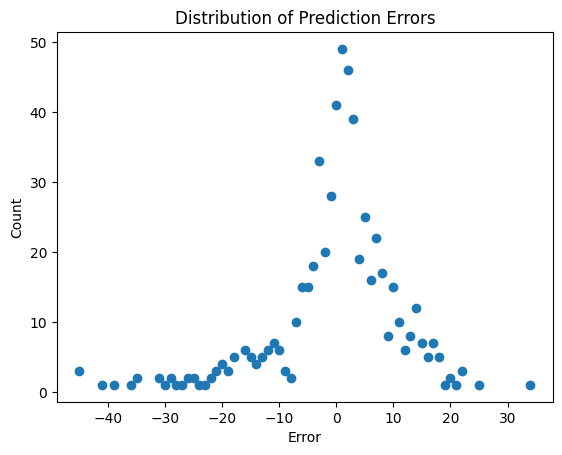

In [53]:
X_train_val_df = step4_dev_norm_df.copy()
X_train_val_df = X_train_val_df

forest = RandomForestRegressor(n_estimators=800, random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest.fit(X_train, y_train)
y_pred = forest.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.224589931506381

In [54]:
imps = sorted(zip(forest.feature_names_in_, forest.feature_importances_), key=lambda x:x[1] , reverse=True)
imps

[('audio_length', np.float64(0.2736047685522468)),
 ('silence_duration', np.float64(0.036762791709208625)),
 ('english', np.float64(0.02720691644320529)),
 ('mfcc_frequency_var_6', np.float64(0.011150853576866406)),
 ('mfcc_frequency_mean_6', np.float64(0.010452026960756998)),
 ('jitter', np.float64(0.009387520416323533)),
 ('mfcc_frequency_mean_9', np.float64(0.009190044246347813)),
 ('mfcc_frequency_mean_10', np.float64(0.007829872819222811)),
 ('mfcc_frequency_mean_4', np.float64(0.007670382410673958)),
 ('fundamental_freq', np.float64(0.0076328227649524495)),
 ('mfcc_frequency_mean_11', np.float64(0.007462219219813298)),
 ('shimmer', np.float64(0.007304392777261126)),
 ('mfcc_frequency_mean_17', np.float64(0.007178195885598866)),
 ('mfcc_frequency_var_5', np.float64(0.006835955979797675)),
 ('dominant_frequency', np.float64(0.006231457319204892)),
 ('mfcc_frequency_mean_12', np.float64(0.006143007330715817)),
 ('num_pauses', np.float64(0.006138589617201013)),
 ('max_pitch', np.floa

In [58]:
print(sum([imp for f, imp in imps[:81]]))

mean_imps = np.mean([imp for f, imp in imps])

print(len([f for f, imp in imps if imp > mean_imps]))

drop_features = [f for f,imp in imps[81:]]
# drop_features.append('audio_length')
drop_features

0.682934755672999
81


['mel_frequency_var_2',
 'harmonic_frequency_var_26',
 'harmonic_frequency_var_23',
 'mel_frequency_var_7',
 'mel_frequency_mean_3',
 'mel_frequency_mean_9',
 'mel_frequency_var_12',
 'spect_frequency_var_1',
 'harmonic_frequency_mean_10',
 'mel_frequency_var_18',
 'harmonic_frequency_mean_29',
 'mel_frequency_var_15',
 'spectrum_wide',
 'harmonic_frequency_mean_4',
 'mel_frequency_var_13',
 'percussion_frequency_var_30',
 'mel_frequency_var_9',
 'harmonic_frequency_var_28',
 'mel_frequency_var_11',
 'spectral_centroid_mean',
 'mel_frequency_mean_6',
 'harmonic_frequency_var_30',
 'harmonic_frequency_var_1',
 'std_coeffs',
 'mel_frequency_var_4',
 'mfcc_frequency_mean_0',
 'mel_frequency_mean_2',
 'mel_frequency_mean_18',
 'mel_frequency_mean_8',
 'spect_frequency_var_23',
 'mel_frequency_mean_7',
 'highest_freq_in_spectrum',
 'harmonic_frequency_mean_16',
 'mel_frequency_mean_5',
 'mel_frequency_var_20',
 'mel_frequency_var_21',
 'harmonic_frequency_mean_11',
 'harmonic_frequency_mean

In [59]:
step4_dev_pruned_df = step4_dev_norm_df.drop(columns=drop_features, axis=1)
step4_eval_pruned_df = step4_eval_norm_df.drop(columns=drop_features, axis=1)

# step4_dev_pruned_df = step4_dev_norm_df.copy()
# step4_eval_pruned_df = step4_eval_norm_df.copy()

10.289016416095853

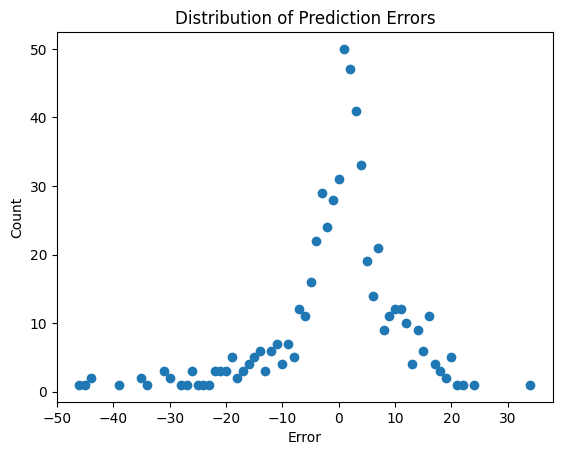

In [63]:
# let us try remove them
X_train_val_df = step4_dev_pruned_df.copy()
X_train_val_df = X_train_val_df

forest_pruned = RandomForestRegressor(n_estimators=400, random_state=341967)

X_train, X_val, y_train, y_val = train_test_split(X_train_val_df, ages_df, test_size=0.2, shuffle=True, random_state=341967)

forest_pruned.fit(X_train, y_train)
y_pred = forest_pruned.predict(X_val)

display(root_mean_squared_error(y_val, y_pred))

_ = plot_error_distripution(y_pred, y_val, 0)
#10.186472864996084

In [64]:
sorted(zip(forest_pruned.feature_names_in_, forest_pruned.feature_importances_), key=lambda x:x[1] , reverse=True)

[('audio_length', np.float64(0.27748626291186357)),
 ('silence_duration', np.float64(0.04200985681784333)),
 ('english', np.float64(0.030432730456941445)),
 ('mfcc_frequency_mean_6', np.float64(0.016507805507134966)),
 ('mfcc_frequency_var_6', np.float64(0.01595061521853717)),
 ('jitter', np.float64(0.015081465294728287)),
 ('mfcc_frequency_mean_9', np.float64(0.013029073706866356)),
 ('mfcc_frequency_mean_4', np.float64(0.012134705203250835)),
 ('mfcc_frequency_mean_10', np.float64(0.011759103622113368)),
 ('shimmer', np.float64(0.011715560117685085)),
 ('mfcc_frequency_var_5', np.float64(0.011628408023571993)),
 ('harmonic_frequency_var_24', np.float64(0.011278407459956626)),
 ('fundamental_freq', np.float64(0.011122851959711506)),
 ('percussion_frequency_var_2', np.float64(0.010523256016649048)),
 ('mfcc_frequency_mean_11', np.float64(0.01041218300712041)),
 ('lowest_freq_in_spectrum', np.float64(0.010284965173171614)),
 ('mfcc_frequency_mean_7', np.float64(0.010251795526218693)),
 

# Upload section

In [65]:
y_eval_pred = forest_pruned.predict(step4_eval_pruned_df)

with open("results.csv", "w") as fout:
    fout.write("Id,Predicted\n")
 
    for id, y in enumerate(y_eval_pred):
        fout.write(f"{id},{y}\n")